# Quick benchmark with new spikeinetrface API with new sorters

In spring 2021 the spikeinterface is refactored deeply.

During this refactoring some sorters have been added.

Here quick benchmark with one simulated dataset with MEArec.


In [7]:
%matplotlib inline

In [8]:
from pathlib import Path
import os
import shutil
from pprint import pprint
import getpass


import numpy as np
import matplotlib.pyplot as plt

import MEArec as mr
import neo
import quantities as pq


import spikeinterface.extractors  as se
import spikeinterface.widgets  as sw
import spikeinterface.sorters  as ss

from spikeinterface.comparison import GroundTruthStudy

In [9]:
basedir = '/mnt/data/sam/DataSpikeSorting/'

basedir = Path(basedir)

workdir = basedir / 'mearec_bench_2021'

study_folder = workdir /'study_mearec_march_2021'

tmp_folder = workdir / 'tmp'
tmp_folder.mkdir(parents=True, exist_ok=True)

## generate recording with mearec

In [ ]:
template_filename = workdir / 'templates_Neuronexus-32_100.h5'
probe = 'Neuronexus-32'
n_cell = 15
duration = 10 * 60.

recording_filename = workdir /  f'recordings_{n_cell}cells_{probe}_{duration:0.0f}s.h5'


fs = 30000.


#~ spgen = mr.SpikeTrainGenerator()
rec_params = mr.get_default_recordings_params()

rec_params['recordings']['fs'] = fs
rec_params['recordings']['sync_rate'] = None
rec_params['recordings']['sync_jitter'] = 5
rec_params['recordings']['noise_level'] = 5
rec_params['recordings']['filter'] = False
rec_params['recordings']['chunk_duration'] = 10.
rec_params['spiketrains']['duration'] = duration
rec_params['spiketrains']['n_exc'] = n_cell
rec_params['spiketrains']['n_inh'] = 0
rec_params['templates']['n_overlap_pairs'] = None
rec_params['templates']['min_dist'] = 0

recgen = mr.gen_recordings(params=rec_params, #spgen=spgen, 
            templates=template_filename, verbose=True,
            n_jobs=1, tmp_mode='memmap',
            tmp_folder=str(tmp_folder))

mr.save_recording_generator(recgen, filename=recording_filename)


### set sorter path

In [3]:
user = getpass.getuser()

kilosort_path = f'/home/{user}/Documents/SpikeInterface/code_sorters/KiloSort1'
ss.KilosortSorter.set_kilosort_path(kilosort_path)

kilosort2_path = f'/home/{user}/Documents/SpikeInterface/code_sorters/Kilosort2'
ss.Kilosort2Sorter.set_kilosort2_path(kilosort2_path)

kilosort2_5_path = f'/home/{user}/Documents/SpikeInterface/code_sorters/Kilosort2.5'
ss.Kilosort2_5Sorter.set_kilosort2_5_path(kilosort2_path)

kilosort3_path = f'/home/{user}/Documents/SpikeInterface/code_sorters/Kilosort3'
ss.Kilosort3Sorter.set_kilosort3_path(kilosort3_path)

ironclust_path = f'/home/{user}/Documents/SpikeInterface/code_sorters/ironclust/'
ss.IronClustSorter.set_ironclust_path(ironclust_path)


Setting KILOSORT_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/KiloSort1
Setting KILOSORT2_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2
Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2
Setting KILOSORT3_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort3
Setting IRONCLUST_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/ironclust


### create study

In [6]:
mearec_filename = workdir / 'recordings_15cells_Neuronexus-32_600s.h5'

if study_folder.is_dir():
    shutil.rmtree(study_folder)

rec  = se.MEArecRecordingExtractor(mearec_filename)
sorting_gt = se.MEArecSortingExtractor(mearec_filename)
print(rec)
print(sorting_gt)

gt_dict = {'rec0' : (rec, sorting_gt) }

study = GroundTruthStudy.create(study_folder, gt_dict)

MEArecRecordingExtractor: 32 channels - 1 segments - 30.0kHz
  file_path: /mnt/data/sam/DataSpikeSorting/mearec_bench_2021/recordings_15cells_Neuronexus-32_600s.h5
MEArecSortingExtractor: 15 units - 1 segments - 30.0kHz
  file_path: /mnt/data/sam/DataSpikeSorting/mearec_bench_2021/recordings_15cells_Neuronexus-32_600s.h5
write_binary_recording with n_jobs 1  chunk_size None


### plot probe

Probe - 32ch


(<matplotlib.collections.PolyCollection at 0x7f93854cc370>,
 <matplotlib.collections.PolyCollection at 0x7f947882e7c0>)

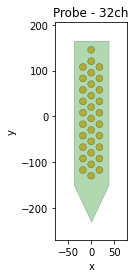

In [14]:
study = GroundTruthStudy(study_folder)
rec = study.get_recording()
probe = rec.get_probe()
print(probe)
from probeinterface.plotting import plot_probe
plot_probe(probe)

### run sorters

In [ ]:
sorter_list = ['spykingcircus', 'kilosort2', 'kilosort3', 'tridesclous']
study = GroundTruthStudy(study_folder)
study.run_sorters(sorter_list, mode_if_folder_exists='overwrite', verbose=False)
study.copy_sortings()

## collect results

In [4]:
study = GroundTruthStudy(study_folder)
study.copy_sortings()


study.run_comparisons(exhaustive_gt=True, delta_time=1.5)


comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [10]:
for (rec_name, sorter_name), comp in comparisons.items():
    print()
    print('*'*20)
    print(rec_name, sorter_name)
    print(comp.count_score)


********************
rec0 spykingcircus
              tp    fn    fp num_gt num_tested tested_id
gt_unit_id                                              
#0             0  2772     0   2772          0        -1
#1          2305     0  2127   2305       4432         0
#2             0  3009     0   3009          0        -1
#3             0  2503     0   2503          0        -1
#4          3135     0     4   3135       3139         2
#5             0  2081     0   2081          0        -1
#6          2192     0     2   2192       2194         5
#7          2723     0    55   2723       2778         3
#8             0  3453     0   3453          0        -1
#9             0  2334     0   2334          0        -1
#10         2280    15     8   2295       2288        11
#11         2588     8    12   2596       2600        10
#12         2721   333  1503   3054       4224         8
#13            0  3020     0   3020          0        -1
#14         3612     0  1070   3612       4682 

## Agreement matrix

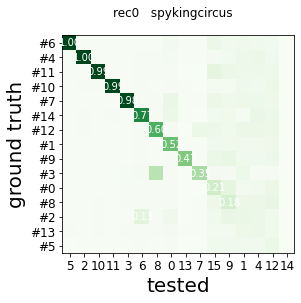

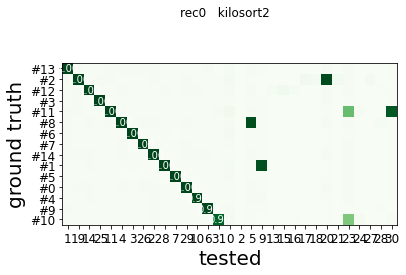

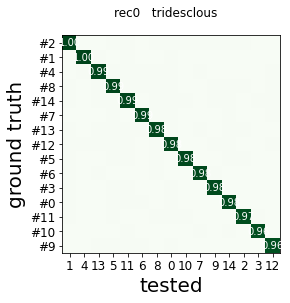

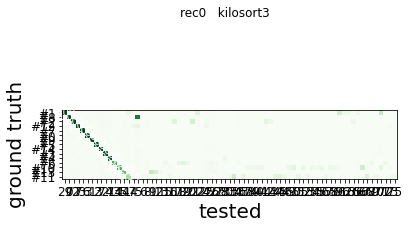

In [11]:
for (rec_name, sorter_name), comp in comparisons.items():
    fig, ax = plt.subplots()
    sw.plot_agreement_matrix(comp, ax=ax)
    fig.suptitle(rec_name+'   '+ sorter_name)

## Accuracy vs SNR